In [1]:
#Separate notebook to work on Topic Modelling with LDA
%pylab inline
from sys import platform
from pprint import pprint
import pandas as pd
from tqdm import trange

if platform == "win32":
    path = 'C:/Users/olive/'
elif platform == "darwin":
    path = '~/'

Populating the interactive namespace from numpy and matplotlib


In [2]:
c_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/comments.csv')
s_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/submissions.csv')

s_df = s_df.sort_values(by='datetime')
c_df = c_df.sort_values(by='datetime')

In [3]:
comments = c_df.reset_index().drop(columns=['id', 'datetime', 'sentiment', 'compound_score', 'submission_id', 'parent_id'], axis=1)

comments = comments.sample(100)

comments.head()

,body,processed_text
292121,especially the part where he got a date,especially the part where he got a date
106358,This will happen if they announce that,this will happen if they announce that
512776,people dont like being stuck at home shocking,people dont like being stuck at home shocking
565577,Taiwan is an extremely dense and urban island....,taiwan is an extremely dense and urban island\...
225477,agreed. will be interesting to see next wednes...,agreed will be interesting to see next wednesd...


In [4]:
# REMOVE EMAILS AND NEWLINE CHARACTERS

data = comments['processed_text'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['especially the part where he got a date']


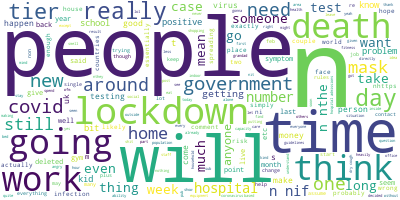

In [5]:
# EXPLORATORY ANALYSIS

from wordcloud import WordCloud

long_string = ','.join(list(comments['processed_text'].values))

wordcloud = WordCloud(background_color="white",
                      max_words=5000,
                      contour_width=3,
                      contour_color='steelblue'
                     )

wordcloud.generate(long_string)

wordcloud.to_image()

In [6]:
# Tokenize words and more text clean-up

import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),
                                            deacc=True))
        
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['especially', 'the', 'part', 'where', 'he', 'got', 'date']


In [7]:
#Bigram and Trigram Phrase Modelling

bigram = gensim.models.Phrases(data_words, 
                               min_count=5, 
                               threshold=100
                              )
trigram = gensim.models.Phrases(bigram[data_words], 
                                threshold=100
                               )

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[0]]])

['especially', 'the', 'part', 'where', 'he', 'got', 'date']


In [8]:
#Remove Stopwords, Make Bigrams and Lemmantize

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from',
                   'subject', 
                   're', 
                   'edu', 
                   'use'])

In [9]:
#Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
import spacy

data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load("en_core_web_sm", disable=['parser',
                                            'ner'])

data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:1])

[['especially', 'part', 'get', 'date']]


In [11]:
#Data Tranformation: Corpus and Dictionary

import gensim.corpora as corpora

id2word = corpora.Dictionary(data_lemmatized)
# id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
# texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [12]:
# Building LDA model

def build_lda(num_topics):
    return gensim.models.LdaModel(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=num_topics,
                                  random_state=100,
                                  update_every=1,
                                  chunksize=100,
                                  passes=10,
                                  alpha='auto',
                                  per_word_topics=True)

# lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=10,
#                                        random_state=100,
#                                        chunksize=100,
#                                        passes=10,
#                                        alpha='auto',
#                                        per_word_topics=True)

In [13]:
from pprint import pprint

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

NameError: name 'lda_model' is not defined

100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


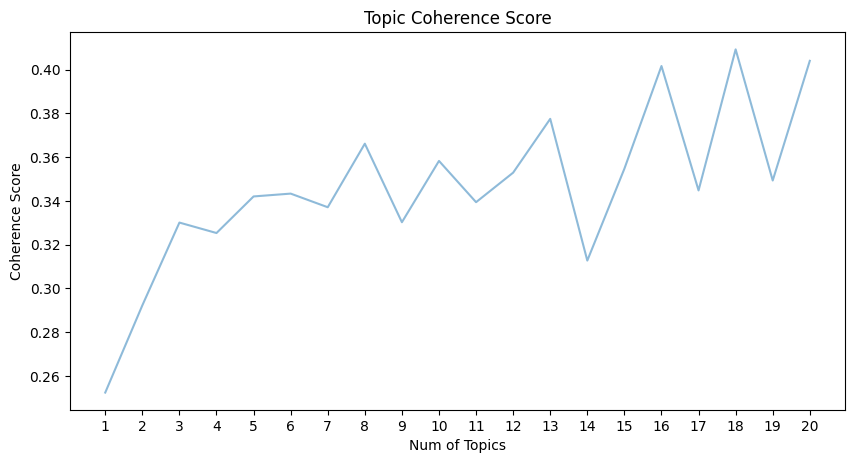

In [14]:
# METHOD FOR TESTING COHERENCE SCORE FOR DIFFERING NUMBERS OF TOPICS

from gensim.models import CoherenceModel

topic_coherence = []
num_topics = 20

for n in trange(1, num_topics + 1):
    
    lda_model = build_lda(n)
    
    # Compute Perplexity
    topic_perplexity = lda_model.log_perplexity(corpus)

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=data_lemmatized, 
                                         dictionary=id2word, 
                                         coherence='c_v')
    
    topic_coherence.append(coherence_model_lda.get_coherence())


x = [i for i in range(1, num_topics + 1)]

fig, ax1 = plt.subplots(1, dpi=100)
fig.set_size_inches(10, 5)

ax1.set_title('Topic Coherence Score')
ax1.set_xlabel('Num of Topics')
ax1.set_ylabel('Coherence Score')
ax1.set_xticks(x)
ax1.plot(x, topic_coherence, alpha=0.5)

In [ ]:
# from gensim.models.wrappers import LdaMallet

mallet_path = './mallet-2.0.8/bin/mallet'
dir(gensim.models)

# ldamallet = gensim.models.wrapper.LdaMallet(mallet_path,
#                       corpus=corpus,
#                       num_topics=3,
#                       id2word=id2word)

In [ ]:
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score

In [ ]:
# Hyperparameter Tuning
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=data_lemmatized, 
                                         dictionary=id2word,
                                         coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [16]:
import pyLDAvis.gensim_models
import os
import pickle
import pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(build_lda(13),
                                     corpus,
                                     id2word)
vis

/Users/ollyjc/Documents/GitHub/COVID-19-Sentiment-and-Compliance-Analyzer/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.091199 -0.096410       1        1  17.694510
5      0.188971  0.013050       2        1  16.955199
11    -0.107115  0.056060       3        1  12.560723
8      0.027861 -0.110329       4        1   8.794383
1     -0.002963 -0.098560       5        1   7.405387
9     -0.005113  0.050686       6        1   6.686531
3      0.058968  0.081450       7        1   6.519781
12    -0.067494  0.091997       8        1   5.502720
4      0.048162  0.003845       9        1   5.029248
2     -0.035425  0.022823      10        1   4.900547
7     -0.006470 -0.048040      11        1   3.226690
0     -0.011871  0.039666      12        1   3.190838
6      0.003688 -0.006239      13        1   1.533444, topic_info=      Term       Freq      Total Category  logprob  loglift
216   news   6.000000   6.000000  Default  30.0000  30.0000
6       do  18.000000  18.000000  Default  29.0000  29.0000
146   tier   9.000000   9.000000  Default  28.0000  28.0000
246   work  11.000000  11.000000  Default  27.0000  27.0000
14   death   9.000000   9.000000  Default  26.0000  26.0000
..     ...        ...        ...      ...      ...      ...
731    pre   0.023217   1.249821  Topic13  -7.1866   0.1918
726    low   0.023211   1.249769  Topic13  -7.1869   0.1916
736    wfm   0.023974   2.520348  Topic13  -7.1545  -0.4775
732   role   0.023461   1.885294  Topic13  -7.1762  -0.2089
21    time   0.023856  14.821786  Topic13  -7.1595  -2.2542

[717 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
130       2  0.699102       achieve
496       9  0.841644      activate
110       1  0.283561      actually
110       3  0.283561      actually
110       4  0.283561      actually
...     ...       ...           ...
241       6  0.283919         wrong
469       8  0.827242  wwwredditcom
155       1  0.493546          year
155       4  0.246773          year
155       7  0.246773          year

[839 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 6, 12, 9, 2, 10, 4, 13, 5, 3, 8, 1, 7])

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

#Can take a while to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], 
                                                  dictionary=id2word, 
                                                  k=k, 
                                                  a=a,
                                                  b=b)
                    print('Alert')
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
                    
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv',
                                       index=False)
    pbar.close()
